# Physics Informed Neural Networks (PINNs) for 2D Heat Equation

## 1. Introduction
In this workbook, we would be training a physics informed neural network model for 1D Heat equation.

$$\frac{\partial u}{\partial t} - \nu \Big( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \Big)= 0$$

Physics informed neural networks is made of a dense neural network that takes in the $(x,t)$ points in the domain and learns the physics from it using PDEs such as the one just above. 

The architecture of the network looks something like this:

![](https://www.researchgate.net/profile/Zhen-Li-105/publication/335990167/figure/fig1/AS:806502679982080@1569296631121/Schematic-of-a-physics-informed-neural-network-PINN-where-the-loss-function-of-PINN.ppm)

We will begin the workbook with few imports and creating some helper functions

## 2. Imports and helper functions

In [5]:
!pip install tensorflow-gpu

  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Using cached tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0


ERROR: tensorflow 2.7.0 has requirement tensorboard~=2.6, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 2.7.0 has requirement tensorflow-estimator<2.8,~=2.7.0rc0, but you'll have tensorflow-estimator 1.14.0 which is incompatible.


In [7]:
import tensorflow as tf
tf.version.VERSION

'2.7.0'

In [8]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import time 
import matplotlib.pyplot as plt
import os
from PIL import Image
t0 = time.time()
save_directory = './results'

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

def plot(geom_time,resolution,data,save_directory,name):  #output_data = pred[:,j]
    img_save_directory = save_directory + 'visualize_result'
    if not os.path.exists(img_save_directory):
        os.makedirs(img_save_directory)
    img_save_directory = img_save_directory + '/'
    fig = plt.figure()
    ims_test = []
    if name[-10:] =='prediction':
        t_max = 1
        t_min = -1
        
    else:
        t_max = np.max(data)
        t_min = np.min(data)
    nx, ny,nt = resolution 
    data = data.reshape((len(data),)) 
    for t in range(nt):
        plt.scatter(geom_time[:,0][nx*ny*t:nx*ny*(t+1)],geom_time[:,1][nx*ny*t:nx*ny*(t+1)], 
            c=data[nx*ny*t:nx*ny*(t+1)].reshape((len(data[nx*ny*t:nx*ny*(t+1)]),)), cmap='jet',vmin=t_min, vmax=t_max, s= 200, marker = 's')
        plt.colorbar()
        plt.xlabel('x domain')
        plt.ylabel('y domain')
        plt.title( 't = ' + "{:.3f}".format(geom_time[:,2][nx*ny*t +1 ]))
        plt.show()
        filename = name + '_' +str(t)
        plt.savefig(os.path.join(img_save_directory, filename + '.png'))
        plt.close()
        im = Image.open(os.path.join(img_save_directory, filename + '.png'))
        ims_test.append(im)    
    ims_test[0].save(os.path.join(img_save_directory + name + '.gif'),save_all = True, 
            append_images = ims_test[1:], optimize = False, duration = 60, loop = 1000)
    im.show()


def plot_mean_data_history(duration, resolution, data,title,save_directory):
    nx,ny,nt = resolution
    m = []
    for t in range(nt):
        mean_t = np.mean(abs(data[nx*ny*t:nx*ny*(t+1)]))
        m.append(mean_t)

    time = np.array(range(nt))*(duration/nt)
    time = time.reshape((nt,1))
    plt.plot(time, np.asarray(m))
    plt.title(title)
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    plt.savefig(os.path.join(save_directory, 'mean_' + title + '_history.png'))


def pde(X, u):
    du_X = tf.gradients(u, X)[0]
    du_x, du_y, du_t = du_X[:, 0:1], du_X[:, 1:2],du_X[:, 2:3]
    du_xx  = tf.gradients(du_x, X)[0][:, 0:1]
    du_yy = tf.gradients(du_y, X)[0][:, 1:2]
    return du_t-0.5*(du_xx + du_yy)
    

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:2])* np.exp(-x[:, 2:3])

## 2. initialization
Initialize the geometry, time domain and the Dirichlet BC and IC

In [9]:
geom = dde.geometry.geometry_2d.Rectangle([-1,-1], [1,1])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [],
    num_domain=40000,
    num_boundary=20000,
    num_initial=10000,
    solution=func,
    num_test=10000,
)

Initialize the network and compile the model

In [10]:
initializer = "Glorot uniform"
optimizer = "adam"


layer_size = [3] + [32]*3 + [1]
activation = "tanh"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(optimizer, lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.046216 s

'compile' took 0.377972 s



## 3. Training


In [11]:
t1 = time.time()

losshistory, train_state = model.train(epochs=10000)
t2 = time.time()
print("training time:", (t2-t1))

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [1.17e-01]    [1.20e-01]    []  
1000      [2.35e-06]    [1.99e-06]    []  
2000      [7.92e-07]    [6.51e-07]    []  
3000      [4.05e-07]    [3.56e-07]    []  
4000      [2.11e-07]    [1.90e-07]    []  
5000      [1.30e-07]    [1.06e-07]    []  
6000      [1.07e-07]    [7.94e-08]    []  
7000      [9.90e-08]    [7.43e-08]    []  
8000      [5.85e-08]    [4.42e-08]    []  
9000      [5.09e-08]    [3.72e-08]    []  
10000     [1.44e-06]    [1.56e-06]    []  

Best model at step 9000:
  train loss: 5.09e-08
  test loss: 3.72e-08
  test metric: []

'train' took 3052.132441 s

training time: 3052.13268327713


## 4. Post-training Visualization

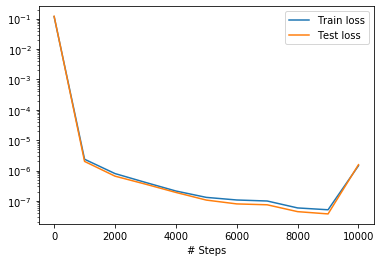

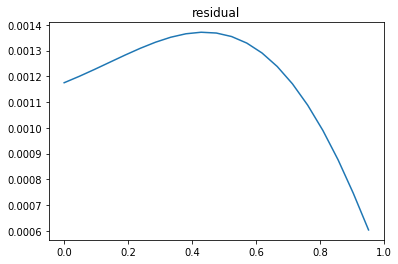

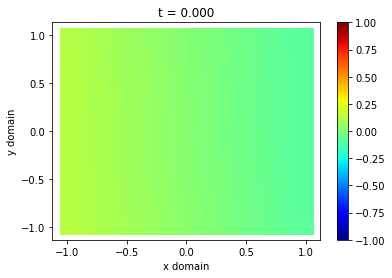

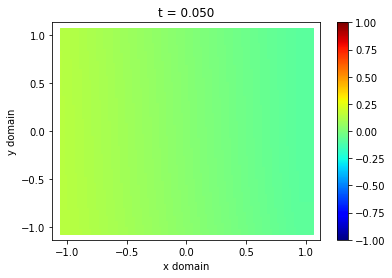

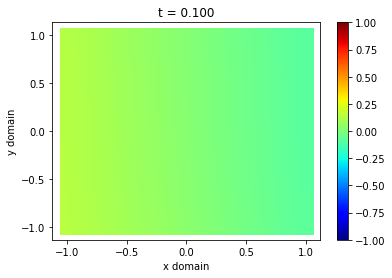

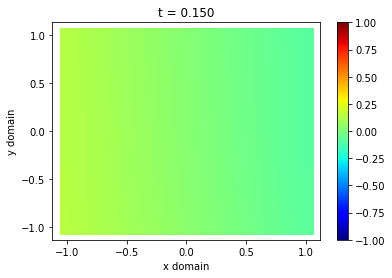

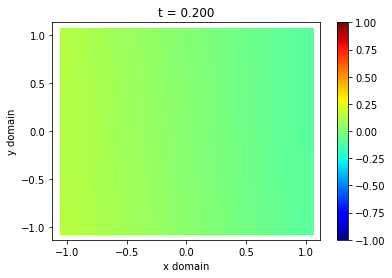

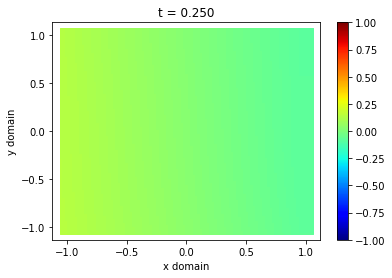

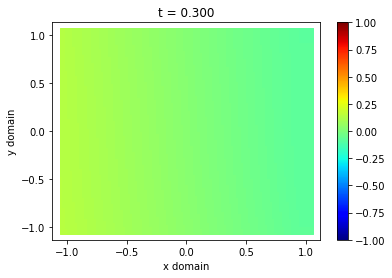

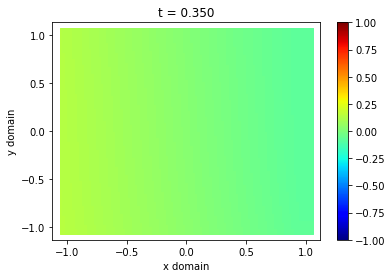

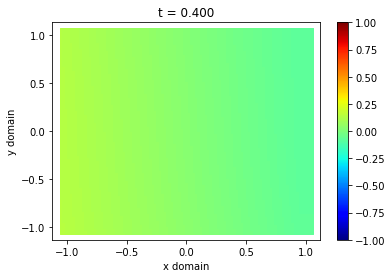

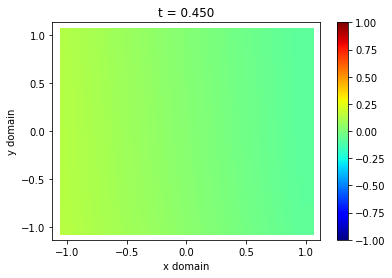

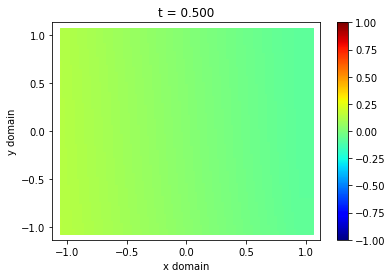

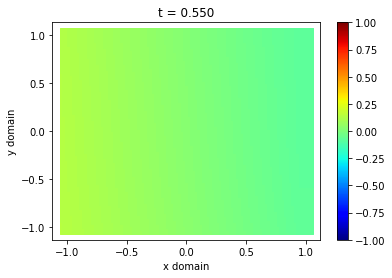

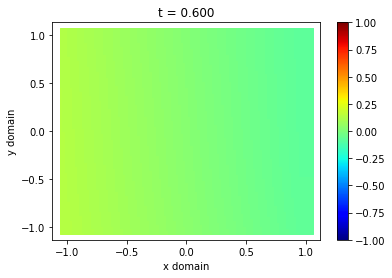

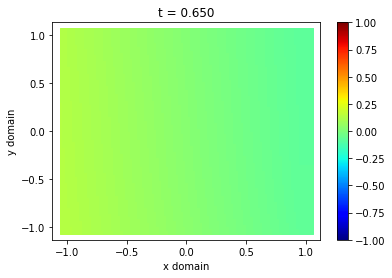

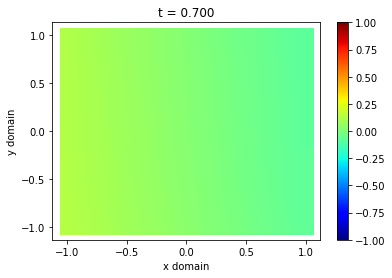

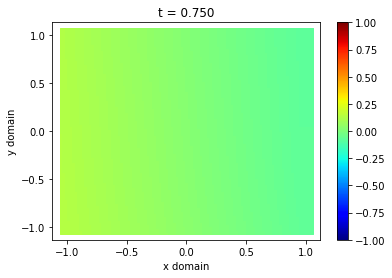

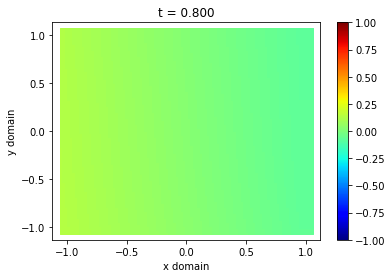

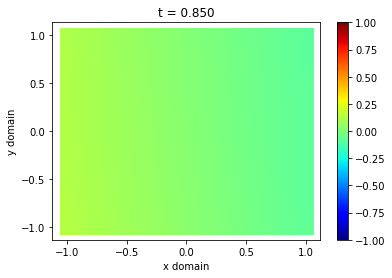

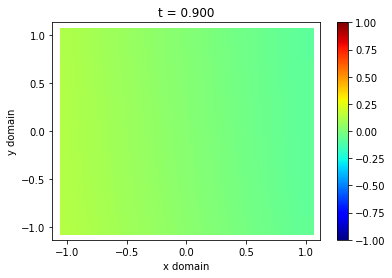

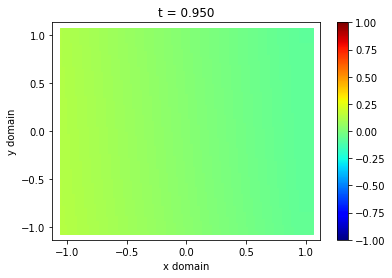

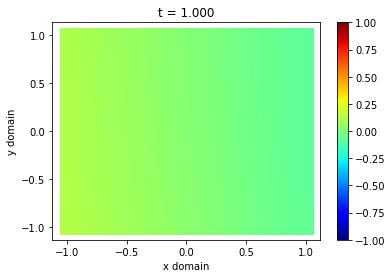

total time
3067.4636771678925


In [12]:
dde.postprocessing.plot_loss_history(losshistory)
plt.show()


x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 21)
test_x , test_t, test_y = np.meshgrid(x, t,y)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y),np.ravel(test_t))).T


prediction = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)
plot_mean_data_history(1, (100,100,21), np.abs(residual),'residual',save_directory)
plot(test_domain,(100,100,21), prediction, save_directory,'prediction')
#plot(test_domain,(100,100,21), residual, save_directory,'prediction')
print("total time")
print(t2-t0)